# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.002006 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in [ComponentType.node, ComponentType.line, ComponentType.source, ComponentType.sym_load]:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array(DatasetType.input, component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.015631 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/PowerGridModel/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.004683 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.000797 s
{'node': 2001, 'line': 2000, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.003964 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Linear Power Flow is 0.000925 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data[ComponentType.sym_load]) 
load_id = input_data[ComponentType.sym_load]["id"]
load_p = input_data[ComponentType.sym_load]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 5e5 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,1.212021e+06,8.519954e+05,7.560917e+05,1.438055e+06,7.396164e+05,6.948326e+05,1.278412e+06,2.304984e+06,9.588319e+05,9.406021e+05,...,2.109739e+05,1.220735e+06,9.715073e+05,1.463336e+06,3.436582e+05,1.764624e+05,5.271467e+05,9.022588e+05,1.055085e+06,1.166126e+06
2022-01-01 01:00:00,8.693649e+05,9.754355e+05,5.038237e+05,1.204583e+06,8.941464e+05,7.513620e+04,1.137045e+06,1.708324e+06,1.342389e+06,1.959986e+06,...,3.954700e+05,6.418734e+05,1.166324e+06,1.218541e+06,1.256374e+06,1.747930e+06,1.375117e+06,5.358348e+04,1.628927e+06,8.230403e+05
2022-01-01 02:00:00,7.923984e+05,1.434058e+06,5.024506e+05,1.627207e+06,1.164684e+06,4.291224e+05,6.576416e+05,9.367841e+05,8.624529e+05,7.692469e+05,...,1.044997e+06,8.009140e+05,1.240692e+06,-2.777931e+04,9.717390e+05,1.261385e+06,8.674137e+05,1.158677e+06,1.320565e+06,1.354277e+06
2022-01-01 03:00:00,1.269392e+06,1.463432e+06,1.018994e+06,1.524115e+06,5.695050e+05,1.577387e+06,1.525168e+05,3.880051e+04,1.383405e+06,5.596274e+05,...,8.182543e+05,1.632945e+06,1.010543e+06,4.009558e+05,1.478580e+06,5.612716e+05,1.245279e+06,1.028181e+06,1.294013e+06,1.162580e+06
2022-01-01 04:00:00,5.811972e+05,1.614621e+06,9.650531e+05,9.365501e+05,1.209160e+06,3.318855e+05,3.351287e+05,1.444800e+06,-2.583068e+05,1.052083e+06,...,4.259355e+05,2.095648e+06,1.368940e+06,1.935897e+05,1.291826e+06,1.599473e+06,1.193099e+06,1.676480e+06,6.758581e+05,5.690138e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,9.550081e+05,1.050358e+06,1.183558e+06,9.563775e+05,9.167803e+05,7.077838e+05,5.764765e+05,1.628767e+06,1.062615e+06,1.755868e+06,...,1.557175e+06,9.978829e+05,1.428223e+06,9.375576e+05,1.544223e+06,1.230698e+06,6.241062e+05,1.172571e+06,1.420599e+06,9.502391e+04
2022-02-11 12:00:00,5.272977e+05,8.443402e+05,1.338616e+06,4.481988e+05,1.426800e+06,2.918600e+05,1.875643e+06,1.500691e+06,1.178919e+06,7.893541e+05,...,7.506101e+05,1.146763e+06,8.711101e+05,8.625724e+05,7.775495e+05,7.721788e+05,1.647198e+06,1.898852e+06,7.778365e+05,-7.752296e+03
2022-02-11 13:00:00,5.938971e+05,1.213851e+06,8.529911e+05,9.887598e+05,1.508931e+06,1.097557e+06,6.580392e+05,1.490143e+06,2.179459e+06,1.281627e+06,...,9.361254e+05,1.127648e+06,1.259310e+06,8.589567e+05,1.479782e+06,8.000593e+05,1.123723e+06,1.760520e+06,4.914607e+05,6.471767e+05
2022-02-11 14:00:00,-7.901549e+04,9.920080e+05,1.248552e+06,9.973602e+05,3.706510e+05,7.892669e+05,1.235685e+06,5.331243e+05,1.387667e+06,1.211971e+06,...,1.480956e+06,8.259945e+05,9.107577e+05,1.661959e+06,1.338668e+06,4.982817e+05,5.063463e+05,1.539331e+06,8.271139e+05,1.865608e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Initialize an empty load profile
load_profile = initialize_array(DatasetType.update, ComponentType.sym_load, df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {ComponentType.sym_load: load_profile}

In [11]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 1.695239 s


In [12]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 2.420980 s


In [13]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.363697 s


## Plotting batch results

Lets say we wish to plot the loading of the `line with id 2007` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

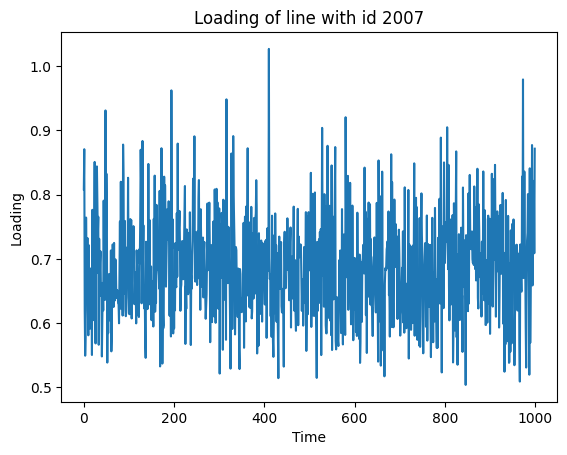

In [14]:
# Plot the loading of line with id 2007 vs time.
line_2007_idx = np.where(output_data[ComponentType.line]["id"] == 2007)
result_loading = output_data[ComponentType.line]["loading"][line_2007_idx]
plt.plot(result_loading)
plt.title('Loading of line with id 2007')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line with id 2007` is greater than `90%`

In [15]:
# Times when loading of line with id 2007 when its greater than 90%
ind = np.where(result_loading > 0.9)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-03 00:00:00', '2022-01-09 02:00:00',
               '2022-01-14 04:00:00', '2022-01-18 02:00:00',
               '2022-01-23 00:00:00', '2022-01-25 04:00:00',
               '2022-02-03 13:00:00', '2022-02-10 13:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [16]:
n_lines = len(input_data[ComponentType.line])

# Initialize an empty line profile
line_profile = initialize_array(DataType.update, ComponentType.line, (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data[ComponentType.line]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {ComponentType.line: line_profile}

In [17]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 3.396744 s


In [18]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 5.572404 s


In [19]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 1.636546 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [20]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 5.430197 s
Execution time for Single thread is 5.460312 s
Execution time for Two threads in parallel is 2.783122 s
Execution time for Four threads in parallel is 1.555401 s
Execution time for Use number of threads based the machine hardware is 0.648667 s
